# Matching tool 

geinspireerd door : https://towardsdatascience.com/dating-algorithms-using-machine-learning-and-ai-814b68ecd75e 
data set verkregen door : https://generatedata.com/generator

## Importeren 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# pip install seaborn
# pip install sklearn
# pip install tensorflo


In [3]:
df0 = pd.read_json("data-for_model.json")  # 500
df1 = pd.read_json("data-for_model2.json")  # 500
df2 = pd.read_json("data-for_model3.json")  # 500

df = pd.concat([df0, df1, df2], ignore_index=True)
df  # 1500


,k1,k2,k3,k4,k5,s1,s2,d4
0,57,28,1,33,54,81,1,32
1,73,73,1,74,94,49,0,36
2,84,49,0,64,3,83,0,24
3,38,11,1,14,94,90,0,36
4,74,39,1,43,67,18,0,32
...,...,...,...,...,...,...,...,...
1495,92,93,1,24,36,73,1,36
1496,1,34,1,78,12,35,0,24
1497,43,81,0,74,66,25,1,24
1498,20,40,0,18,88,99,0,32


## Voorbewerken van de data 

In [4]:
from sklearn.preprocessing import StandardScaler

# scaling the data
scaler = StandardScaler().fit(df)
array_scaled = scaler.transform(df)


In [5]:
df_scaled = pd.DataFrame(array_scaled, columns=[
                         'k1', 'k2', 'k3', 'k4', 'k5', 's1', 's2', 'd4'])
df_scaled


,k1,k2,k3,k4,k5,s1,s2,d4
0,0.208890,-0.713576,0.960769,-0.560722,0.147341,1.028597,1.009377,-0.234507
1,0.756500,0.828438,0.960769,0.868269,1.540860,-0.056016,-0.990710,0.564950
2,1.132982,0.006031,-1.040833,0.519735,-1.629395,1.096385,-0.990710,-1.833422
3,-0.441396,-1.296114,0.960769,-1.222938,1.540860,1.333644,-0.990710,0.564950
4,0.790726,-0.336639,0.960769,-0.212188,0.600235,-1.106734,-0.990710,-0.234507
...,...,...,...,...,...,...,...,...
1495,1.406787,1.513778,0.960769,-0.874403,-0.479742,0.757444,1.009377,0.564950
1496,-1.707744,-0.507974,0.960769,1.007683,-1.315853,-0.530534,-0.990710,-1.833422
1497,-0.270268,1.102574,-1.040833,0.868269,0.565397,-0.869475,1.009377,-1.833422
1498,-1.057457,-0.302372,-1.040833,-1.083524,1.331832,1.638691,-0.990710,-0.234507


In [6]:
# bewijs dat het genormaliseerd :
df_scaled.mean()

# afgerond is dit 0 --> goed genormaliseerd


k1   -5.388282e-17
k2    6.335673e-17
k3   -1.894781e-17
k4   -2.842171e-17
k5    1.042129e-16
s1   -6.868580e-17
s2   -1.527667e-16
d4    2.723747e-16
dtype: float64

## Cluster methode bepalen

In [7]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# kiezen van het aantal clusters

cluster_cnt = [i for i in range(2, 40, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
s_scoresA = []
db_scoresA = []

s_scoresB = []
db_scoresB = []

# Looping through different iterations for the number of clusters
for i in cluster_cnt:

    # Hierarchical Agglomerative Clustering with different number of clusters
    hac = AgglomerativeClustering(n_clusters=i)

    hac.fit(df_scaled)

    cluster_assignmentsA = hac.labels_

    # KMeans Clustering with different number of clusters
    k_means = KMeans(n_clusters=i)

    k_means.fit(df_scaled)

    cluster_assignmentsB = k_means.predict(df_scaled)

    # Appending the scores to the empty lists
    s_scoresA.append(silhouette_score(df_scaled, cluster_assignmentsA))
    db_scoresA.append(davies_bouldin_score(df_scaled, cluster_assignmentsA))

    s_scoresB.append(silhouette_score(df_scaled, cluster_assignmentsB))
    db_scoresB.append(davies_bouldin_score(df_scaled, cluster_assignmentsB))


In [8]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """

    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[
                      i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y

    print('Max Value:\nCluster #',
          df[df['Cluster Score'] == df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #',
          df[df['Cluster Score'] == df['Cluster Score'].min()])

    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16, 6))
    plt.style.use('ggplot')
    plt.plot(x, y)
    plt.xlabel('Het aantal clusters')
    plt.ylabel('Score')
    plt.show()


Grafiek 1  - "The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect. "

https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam#:~:text=The%20silhouette%20score%20of%201,value%20of%20the%20K%20(no.


Grafiek 2 - "Davies-Bouldin index is a validation metric that is often used in order to evaluate the optimal number of clusters to use. It is defined as a ratio between the cluster scatter and the cluster's separation and a lower value will mean that the clustering is better " 

https://stackoverflow.com/questions/59279056/davies-bouldin-index-higher-or-lower-score-better#:~:text=Davies%2DBouldin%20index%20is%20a,that%20the%20clustering%20is%20better.


Max Value:
Cluster #    Cluster Score
5       0.128243

Min Value:
Cluster #     Cluster Score
21       0.089886


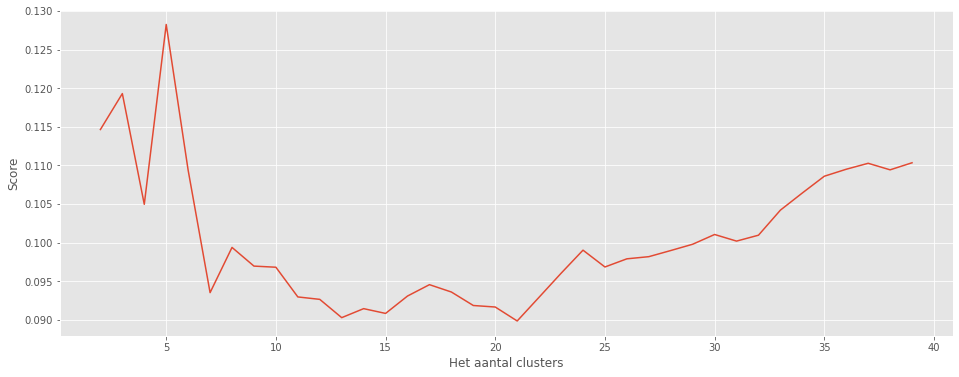

Max Value:
Cluster #    Cluster Score
2       2.766309

Min Value:
Cluster #     Cluster Score
39       1.709474


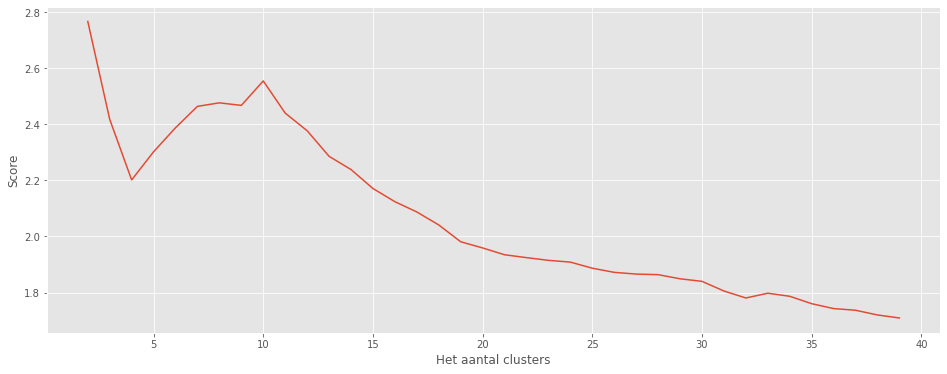

In [9]:
# Running the function on the list of scores
plot_evaluation(s_scoresA)
plot_evaluation(db_scoresA)


Dus vanuit deze twee grafieken is 16 het optimale aantal clusters. En gebruiken kmeans 

### AgglomerativeClustering

grafiek 1 de max is bij 5 clusters met een waarde van 0.128243

grafiek 2 de min is bij 19 clusters met een waarde van 1.61575

Max Value:
Cluster #     Cluster Score
37       0.147525

Min Value:
Cluster #    Cluster Score
8       0.109671


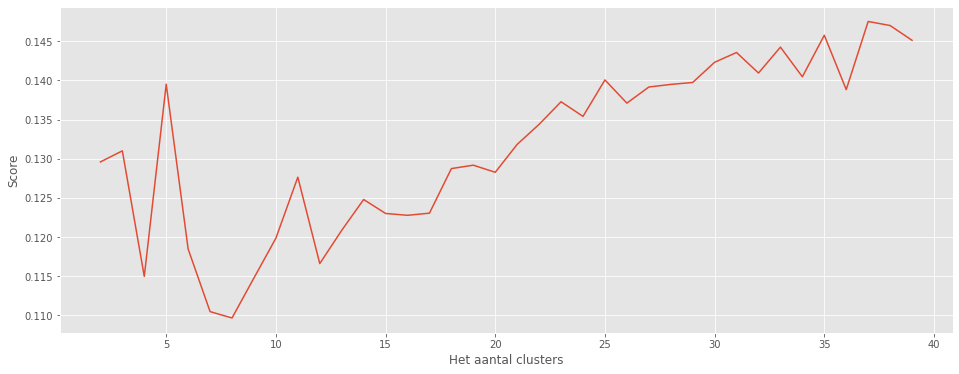

Max Value:
Cluster #    Cluster Score
2       2.598657

Min Value:
Cluster #     Cluster Score
37       1.522244


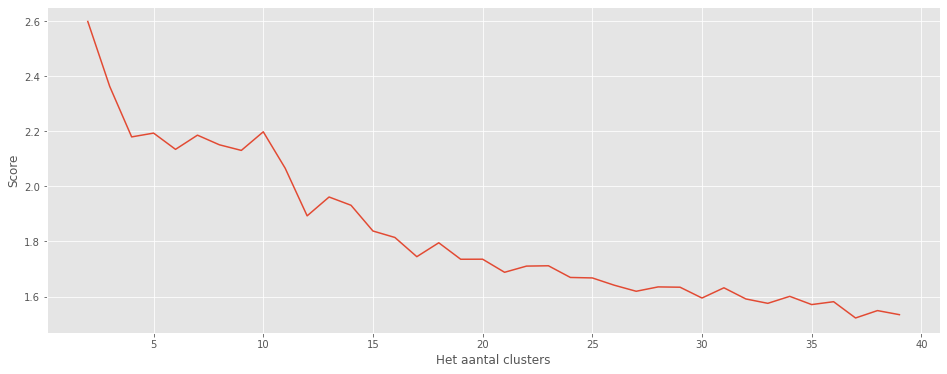

In [10]:
plot_evaluation(s_scoresB)
plot_evaluation(db_scoresB)


### Kmeans 
grafiek 1 de max is bij 17 clusters met een waarde van 0.140338

grafiek 2 de min is bij 19 clusters met een waarde van 1.595732

### Conclusie 


## Clusteren 

In [11]:
# Instantiating HAC

NB_CLUSTERS = 5 
hac = KMeans(n_clusters= NB_CLUSTERS) # 20 was beste resultaat tot nu toe 

# AgglomerativeClustering
# 5         r2 : 0.818 , RMSE : 0.626 , MEA : 0.43 <-- best 
# 16        r2 : 0.477 , RMSE : 3.391 , MEA : 2.65 
# 25        r2 : 0.488 , RMSE : 5.166 , MEA : 4.12
# 30        r2 : 0.416 , RMSE : 6.519 , MEA : 5.05    

# KMeans 
# 5         r2 : 0.921, RMSE : 0.409, MEA : 0.306 <-- best model 2 
# 16        r2 : 0.518, RMSE : 3.308, MEA : 2.518 
# 25        r2 : 0.387, RMSE : 5.674, MEA : 4.729 
# 30        r2 : 0.439, RMSE : 6.400, MEA : 5.089 

# Fitting
hac.fit(df_scaled)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Assigning the clusters to each profile
df_scaled['Cluster #'] = cluster_assignments

# Viewing the dating profiles with cluster assignments
df_scaled


,k1,k2,k3,k4,k5,s1,s2,d4,Cluster #
0,0.208890,-0.713576,0.960769,-0.560722,0.147341,1.028597,1.009377,-0.234507,3
1,0.756500,0.828438,0.960769,0.868269,1.540860,-0.056016,-0.990710,0.564950,4
2,1.132982,0.006031,-1.040833,0.519735,-1.629395,1.096385,-0.990710,-1.833422,1
3,-0.441396,-1.296114,0.960769,-1.222938,1.540860,1.333644,-0.990710,0.564950,4
4,0.790726,-0.336639,0.960769,-0.212188,0.600235,-1.106734,-0.990710,-0.234507,4
...,...,...,...,...,...,...,...,...,...
1495,1.406787,1.513778,0.960769,-0.874403,-0.479742,0.757444,1.009377,0.564950,3
1496,-1.707744,-0.507974,0.960769,1.007683,-1.315853,-0.530534,-0.990710,-1.833422,1
1497,-0.270268,1.102574,-1.040833,0.868269,0.565397,-0.869475,1.009377,-1.833422,1
1498,-1.057457,-0.302372,-1.040833,-1.083524,1.331832,1.638691,-0.990710,-0.234507,0


In [12]:
df['k3'] = df['k3'] * 100
df['s2'] = df['s2'] * 100
df

,k1,k2,k3,k4,k5,s1,s2,d4
0,57,28,100,33,54,81,100,32
1,73,73,100,74,94,49,0,36
2,84,49,0,64,3,83,0,24
3,38,11,100,14,94,90,0,36
4,74,39,100,43,67,18,0,32
...,...,...,...,...,...,...,...,...
1495,92,93,100,24,36,73,100,36
1496,1,34,100,78,12,35,0,24
1497,43,81,0,74,66,25,100,24
1498,20,40,0,18,88,99,0,32


C:\Users\Merel\AppData\Local\Temp/ipykernel_13444/3016453159.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter)


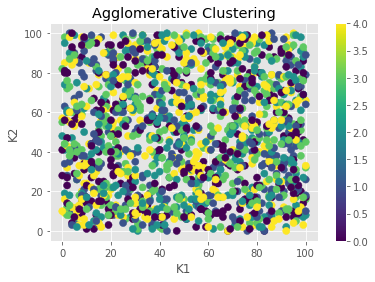

In [13]:
df["Clusters"] = df_scaled['Cluster #']
data = df
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data['k1'], [data['k2']], c=data["Clusters"], s=50)
ax.set_title("Agglomerative Clustering")
ax.set_xlabel("K1")
ax.set_ylabel("K2")
plt.colorbar(scatter)
plt.show()


In [14]:
df_grouped = df.groupby(by=["Clusters"]).mean()
df_grouped


,k1,k2,k3,k4,k5,s1,s2,d4
Clusters,,,,,,,,
0,49.836601,46.983660,0.000000,50.258170,49.882353,51.810458,0.00000,35.071895
1,50.007663,47.609195,50.957854,52.279693,47.157088,54.950192,47.89272,24.000000
2,53.069930,48.734266,0.000000,48.132867,51.947552,49.552448,100.00000,35.216783
3,51.674699,49.852410,100.000000,47.283133,50.719880,48.957831,100.00000,35.313253
4,49.869841,50.615873,100.000000,48.076190,48.850794,48.752381,0.00000,34.819048


hierboven staan alle gemiddelde van de verschillende clusters. Op deze clusters gaat er dus een model gemaakt worden. 

## TF -Model 

In [15]:
np.set_printoptions(precision=3, suppress=True)


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [17]:
print(tf.__version__)


2.9.1


In [18]:
dataset = df.copy()
dataset.isna().sum()


k1          0
k2          0
k3          0
k4          0
k5          0
s1          0
s2          0
d4          0
Clusters    0
dtype: int64

Geen NaN of gemiste data. --> data klaar voor training

In [19]:
# Data splitsen in training en test sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)


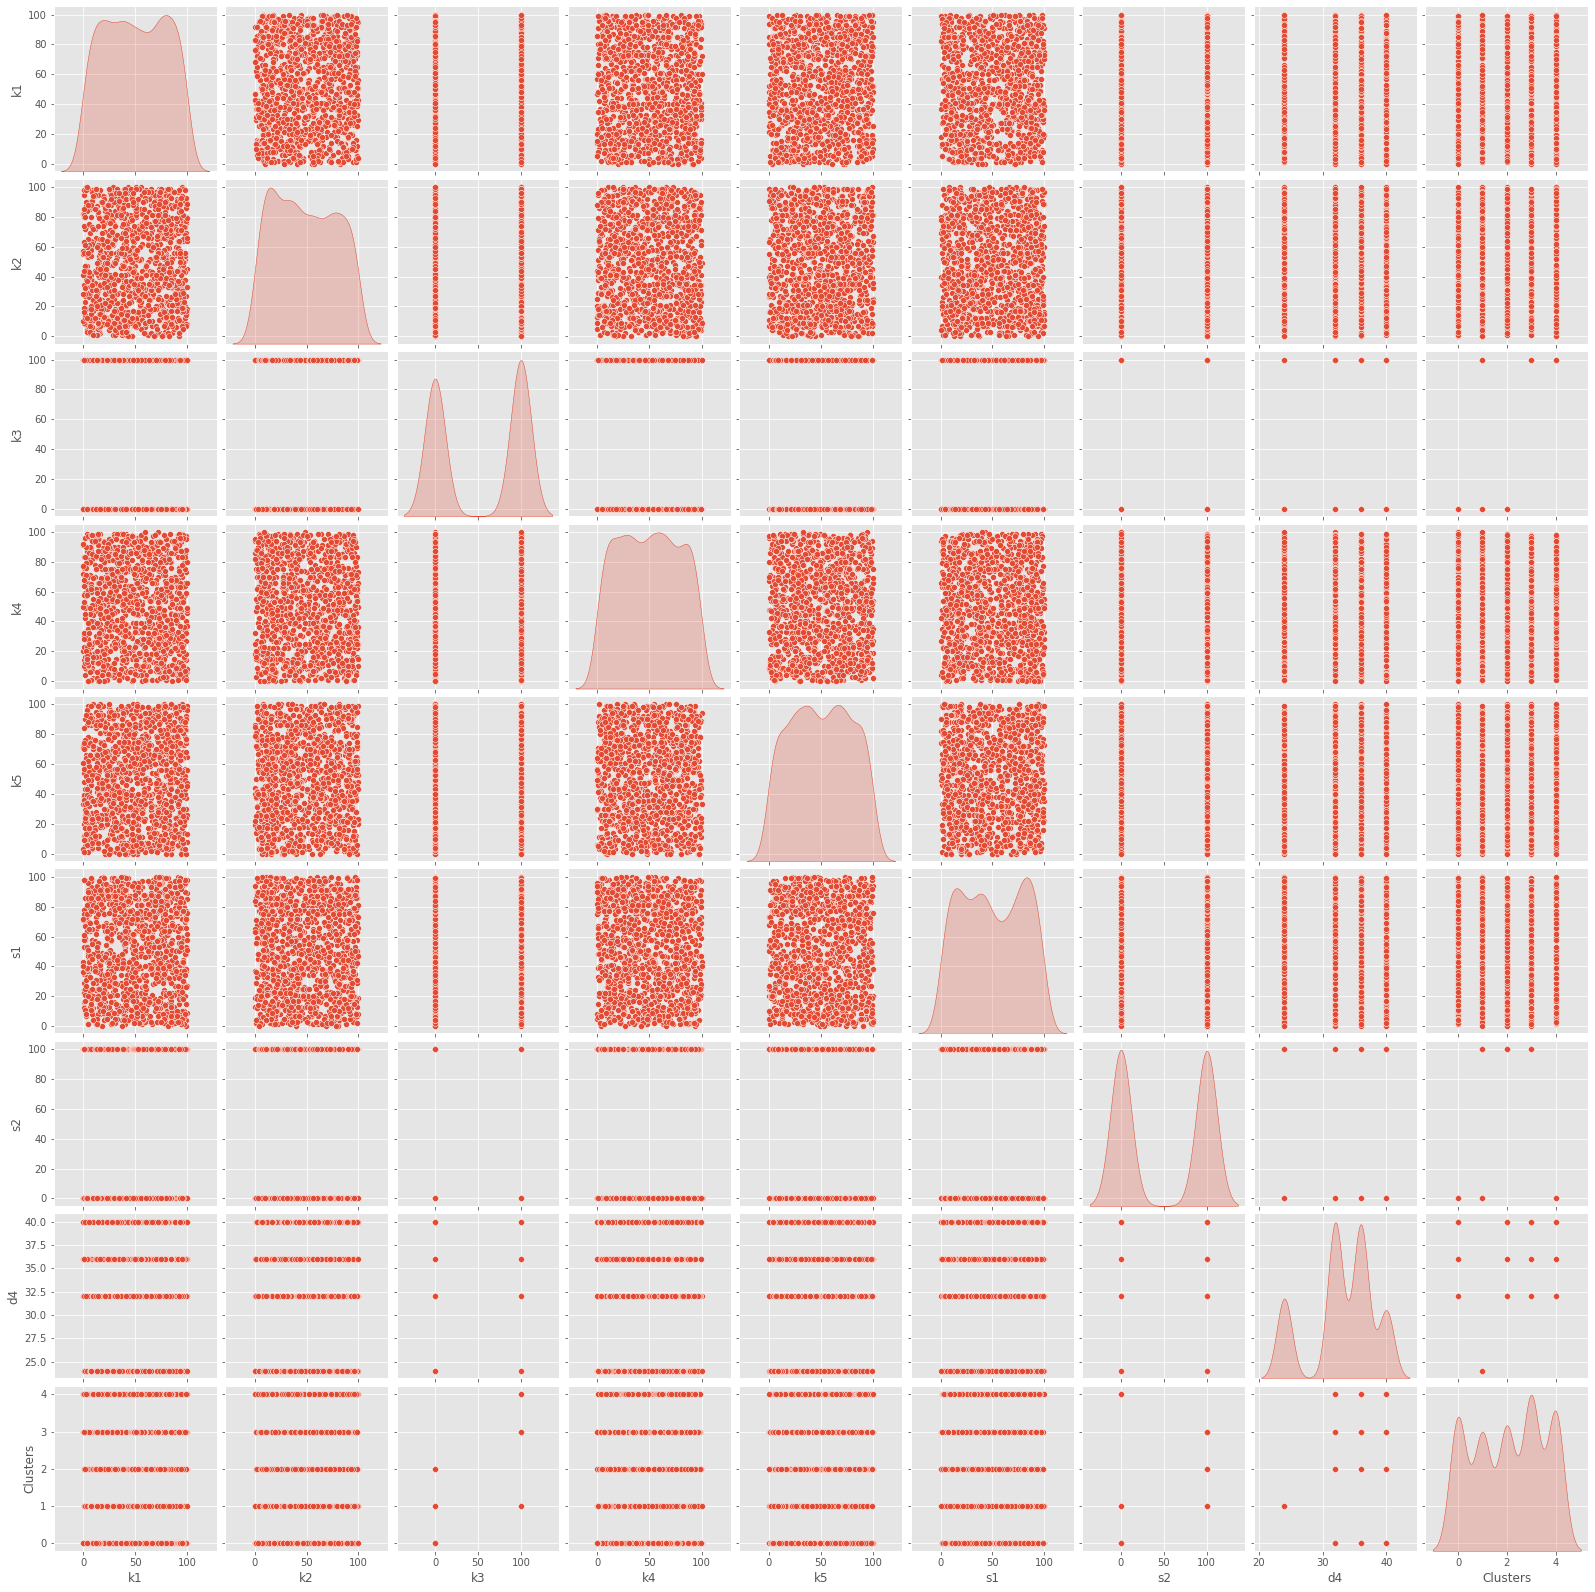

In [20]:
sns.pairplot(train_dataset, diag_kind='kde')


De grafiek hierboven laat zien dat er geen duidelijke functies zijn tussen het resultaat (het cluster nummer) en de andere colums. 

In [21]:
# Nu verdelen we de dataset in train en test
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Clusters')
test_labels = test_features.pop('Clusters')


In [22]:
dataset.keys()

Index(['k1', 'k2', 'k3', 'k4', 'k5', 's1', 's2', 'd4', 'Clusters'], dtype='object')

In [23]:
# data die we in het model.js file kunnen gebruiken 
train_features.to_csv("./ModelData/train_features.csv")
train_labels.to_csv("./ModelData/train_labels.csv")
test_features.to_csv("./ModelData/test_features.csv")
test_labels.to_csv("./ModelData/test_labels.csv")
dataset.to_csv("./ModelData/totaal.csv", index = False)


Om de verschillende colommen te normaliseren gebruiken we de keras normalisatie laag 

In [24]:
from tensorflow.keras.layers import Normalization

normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


[[50.183 48.57  53.167 49.394 49.992 50.132 49.833 33.13 ]]


Hierboven zie je het verschil tussen genormaliseerd en rauwe data. Genormaliseerde data zorgt ervoor dat in het neurale netwerk de gewichten die aan elke berekening/handeling worden gehangen, sneller berekent kunnen worden. 

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from math import sqrt 

def evaluation(test, predict):

    a = plt.axes(aspect='equal')
    plt.scatter(test, predict)
    plt.xlabel('Echte waarden [Clusters]')
    plt.ylabel('Voorspelling  [Clusters]')
    lims = [0, NB_CLUSTERS]  # clusters lopen van 0 tot 19
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)

    # r2-score is altijd tussen 0 en 1 --> hoe hoger hoe beter
    x = r2_score(test, predict)
    # mean squared error --> hoe dichter bij nul hoe beter
    # tussen 0.2 en 0.5 --> goed model 
    y = mean_squared_error(test, predict)
    print("0 < r2 score < 1, best 1                     ", x)
    print("root mean square error (RMSE), best 0        ", sqrt(y))
    print("mea, best 0                                  ", mae(test, predict))


In [26]:
def build_and_compile_model1(norm):
    model = keras.Sequential([
        norm,
        #layers.Dense(8, activation='relu'),
        layers.Dropout(.2, input_shape=(2,)),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  metrics=["accuracy"],
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model


In [27]:
model1 = build_and_compile_model1(normalizer)
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 98
Trainable params: 81
Non-trainable params: 17
_________________________________________________________________


In [28]:
history = model1.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)


In [29]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 5])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


def plot_acc(history):
    plt.plot(history.history['accuracy'], label='accc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)


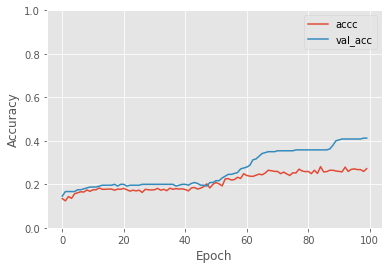

In [30]:
plot_acc(history)

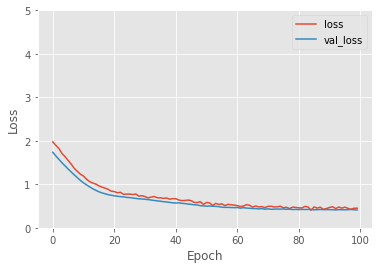

In [31]:
plot_loss(history)

In [32]:
model1.evaluate(test_features, test_labels, verbose=0)


[0.4181402623653412, 0.3866666555404663]

x is de gemiddelde absolute afwijking dit berekent het gemiddelde verschil tussen de berekende en de echte waarden. Hoe kleiner deze is, hoe beter het model getraind is. 

10/10 [==============================] - 0s 1ms/step
0 < r2 score < 1, best 1                      0.8766432132975428
root mean square error (RMSE), best 0         0.5057215194543745
mea, best 0                                   0.41814025027211754


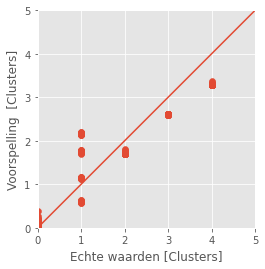

In [33]:
test_predictions = model1.predict(test_features).flatten()

evaluation(test_labels, test_predictions)


Hoe dichter de punten bij de rechte lijn liggen. Hoe beter het model voorspelt. 

interessante layers : 
* Embedding layer 
* Dropout layer
* Noise layer 


In [130]:

def build_and_compile_model2():
    model = keras.Sequential([

        layers.InputLayer(input_shape=(8,)),
        layers.LayerNormalization(axis=-1),
        layers.Dense(16, activation='relu'),
        layers.Dropout(.3, input_shape=(16,)),
        layers.GaussianNoise(stddev=0.2, seed=None),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  metrics=["accuracy"],
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model


In [131]:
model2 = build_and_compile_model2()
model2.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_7 (Laye  (None, 8)                16        
 rNormalization)                                                 
                                                                 
 dense_57 (Dense)            (None, 16)                144       
                                                                 
 dropout_18 (Dropout)        (None, 16)                0         
                                                                 
 gaussian_noise_17 (Gaussian  (None, 16)               0         
 Noise)                                                          
                                                                 
 dense_58 (Dense)            (None, 16)                272       
                                                                 
 dense_59 (Dense)            (None, 1)               

In [132]:
history2 = model2.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

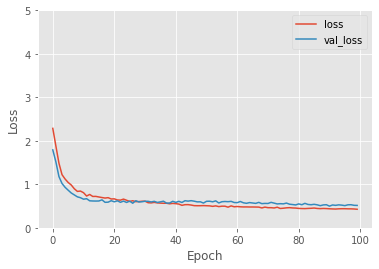

In [133]:
plot_loss(history2)

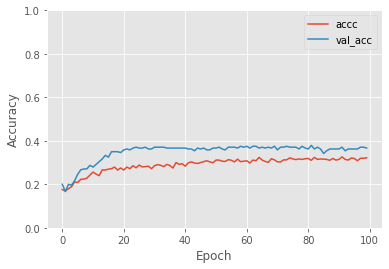

In [134]:
plot_acc(history2)


In [135]:
model2.evaluate(test_features, test_labels, verbose=0)


[0.4920988976955414, 0.34333333373069763]

10/10 [==============================] - 0s 1ms/step
0 < r2 score < 1, best 1                      0.6848807048382601
root mean square error (RMSE), best 0         0.8082903768654761
mea, best 0                                   0.42


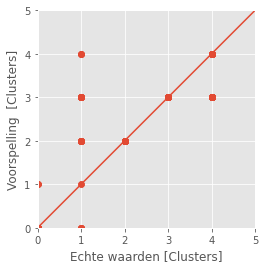

In [136]:
test_predictions2 = model2.predict(test_features)

# maakt de waarden naar de dicht dichtsbijzijnde int 
tp2 = np.rint(test_predictions2)

evaluation(test_labels, tp2)


In [137]:
model2.save(filepath = "./model/")

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


In [138]:
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Merel\AppData\Local\Temp\tmpwro47j1n\assets


INFO:tensorflow:Assets written to: C:\Users\Merel\AppData\Local\Temp\tmpwro47j1n\assets


In [43]:
# pip install tensorflowjs 
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model2, "./finalModel29")

In [128]:

model0 = keras.Sequential([
    normalizer, 
    layers.Dense(8, activation='relu'),
    layers.Dropout(.3, input_shape=(8,)),
    layers.GaussianNoise(stddev=0.2, seed=None),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model0.compile(loss='mean_absolute_error',
              metrics=["accuracy"],
              optimizer=tf.keras.optimizers.Adam(0.001))

model0.summary() 

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense_54 (Dense)            (None, 8)                 72        
                                                                 
 dropout_17 (Dropout)        (None, 8)                 0         
                                                                 
 gaussian_noise_16 (Gaussian  (None, 8)                0         
 Noise)                                                          
                                                                 
 dense_55 (Dense)            (None, 16)                144       
                                                                 
 dense_56 (Dense)            (None, 1)               

In [129]:
model3 = build_and_compile_model3(normalizer)
model3.summary()


NameError: name 'build_and_compile_model3' is not defined

In [ ]:
df

In [ ]:
history3 = model3.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=200)

plot_loss(history3)


In [ ]:
plot_acc(history3)

In [ ]:
model3.evaluate(test_features, test_labels, verbose=0)


In [ ]:
test_predictions3 = model3.predict(test_features)

evaluation(test_labels, test_predictions3)


if the chosen model fits worse than a horizontal line, then R2 is negative.